## ** <font color='red'> We updated the graphs to be in percentage instead of count as discussed in the presentation </font>


In [2]:
# Common imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score
from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.linear_model import Perceptron



# global variables
SALARY_DATA_PATH = r"salary.csv"
RANDOM_STATE = 42

# **Retrieve the Data**

In [3]:
def load_data(path=SALARY_DATA_PATH):
    return pd.read_csv(path)

In [22]:
salary = load_data()
salary = salary.applymap(lambda x: x.strip() if isinstance(x, str) else x) # for removing '\n' '\t' from strings
salary.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## **A quick look at the Data**

In [ ]:
salary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  salary          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [ ]:
salary.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [ ]:
d = salary['salary']
d.value_counts()

 <=50K    24720
 >50K      7841
Name: salary, dtype: int64

In [ ]:
labelencoder = LabelEncoder()
numerical_salary = pd.DataFrame.copy(salary)
numerical_salary['workclass'] = labelencoder.fit_transform(salary['workclass'])
numerical_salary['education'] = labelencoder.fit_transform(salary['education'])
numerical_salary['marital-status'] = labelencoder.fit_transform(salary['marital-status'])
numerical_salary['occupation'] = labelencoder.fit_transform(salary['occupation'])
numerical_salary['relationship'] = labelencoder.fit_transform(salary['relationship'])
numerical_salary['race'] = labelencoder.fit_transform(salary['race'])
numerical_salary['sex'] = labelencoder.fit_transform(salary['sex'])
numerical_salary['native-country'] = labelencoder.fit_transform(salary['native-country'])

numerical_salary.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,7,77516,9,13,4,1,1,4,1,2174,0,40,39,<=50K
1,50,6,83311,9,13,2,4,0,4,1,0,0,13,39,<=50K
2,38,4,215646,11,9,0,6,1,4,1,0,0,40,39,<=50K
3,53,4,234721,1,7,2,6,0,2,1,0,0,40,39,<=50K
4,28,4,338409,9,13,2,10,5,2,0,0,0,40,5,<=50K


In [ ]:
mapping = {
    '<=50K': 0,
    '>50K': 1
}
numerical_salary['salary'] = numerical_salary['salary'].replace(mapping)
numerical_salary

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,7,77516,9,13,4,1,1,4,1,2174,0,40,39,0
1,50,6,83311,9,13,2,4,0,4,1,0,0,13,39,0
2,38,4,215646,11,9,0,6,1,4,1,0,0,40,39,0
3,53,4,234721,1,7,2,6,0,2,1,0,0,40,39,0
4,28,4,338409,9,13,2,10,5,2,0,0,0,40,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,4,257302,7,12,2,13,5,4,0,0,0,38,39,0
32557,40,4,154374,11,9,2,7,0,4,1,0,0,40,39,1
32558,58,4,151910,11,9,6,1,4,4,0,0,0,40,39,0
32559,22,4,201490,11,9,4,1,3,4,1,0,0,20,39,0


In [ ]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

### Replace '?' in 'native country' column to 'Unknown'

In [ ]:
qMark = ' ?'
salary['native-country'] = salary['native-country'].replace(qMark, 'Unknown')

### We can use stratified sampling to divide the data. This way, the right amount of instances are sampled to guarantee the test set represents the overall population.

In [ ]:
def split_train_test_stratified(data, test_ratio=0.2, column_name='salary', random_state=RANDOM_STATE):
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_ratio, random_state=random_state)
    for train_index, test_index in split.split(data, data[column_name]):
        train = data.loc[train_index]
        test = data.loc[test_index]
        return train.reset_index(drop=True), test.reset_index(drop=True)


train_set, test_set = split_train_test_stratified(data=salary)

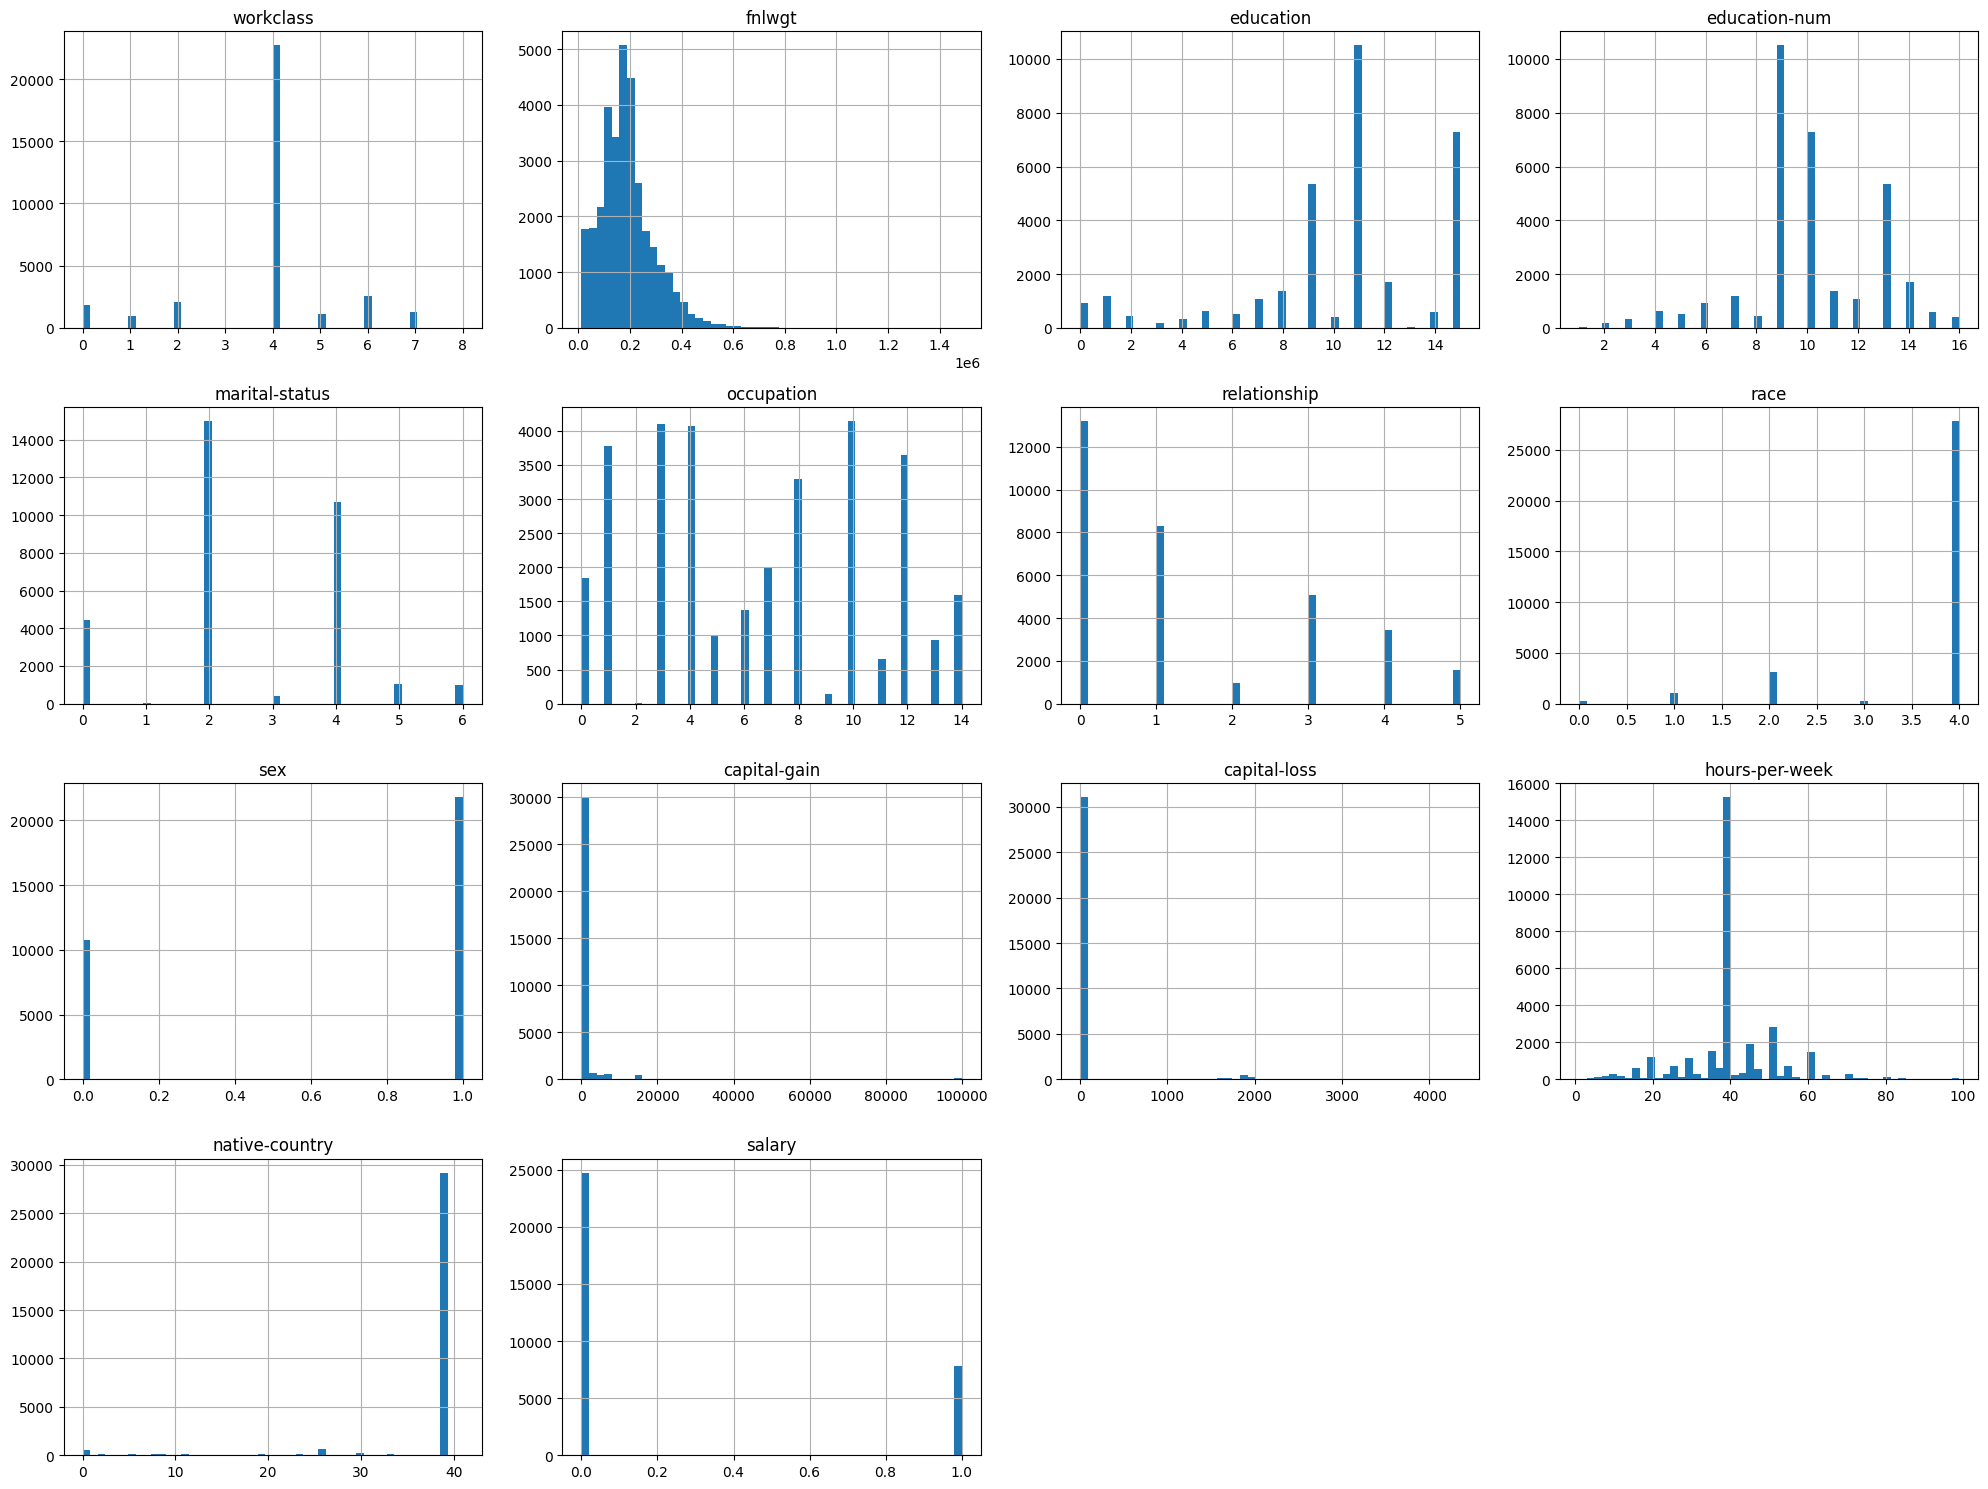

In [ ]:
numerical_salary[numerical_salary.columns[1:]].hist(bins=50, figsize=(20,15))
plt.tight_layout()
plt.show()

**CHALLENGE:**

The histogram shows that the salary column is imbalanced. If we split the data randomly into a training and test set, there is a risk of sampling bias. In other words, if we randomly split the data we could get a different distribution of the labels which would misrepresent the actual distribution. This could affect the results of the trained models, especially since we only have 30,000 samples.

**SOLUTION:**

We can use stratified sampling to divide the data. This way, the right amount of instances are sampled to guarantee the test set represents the overall population.



# **Answering our questions**

# **1. What is The correlation between the data and the salary?**

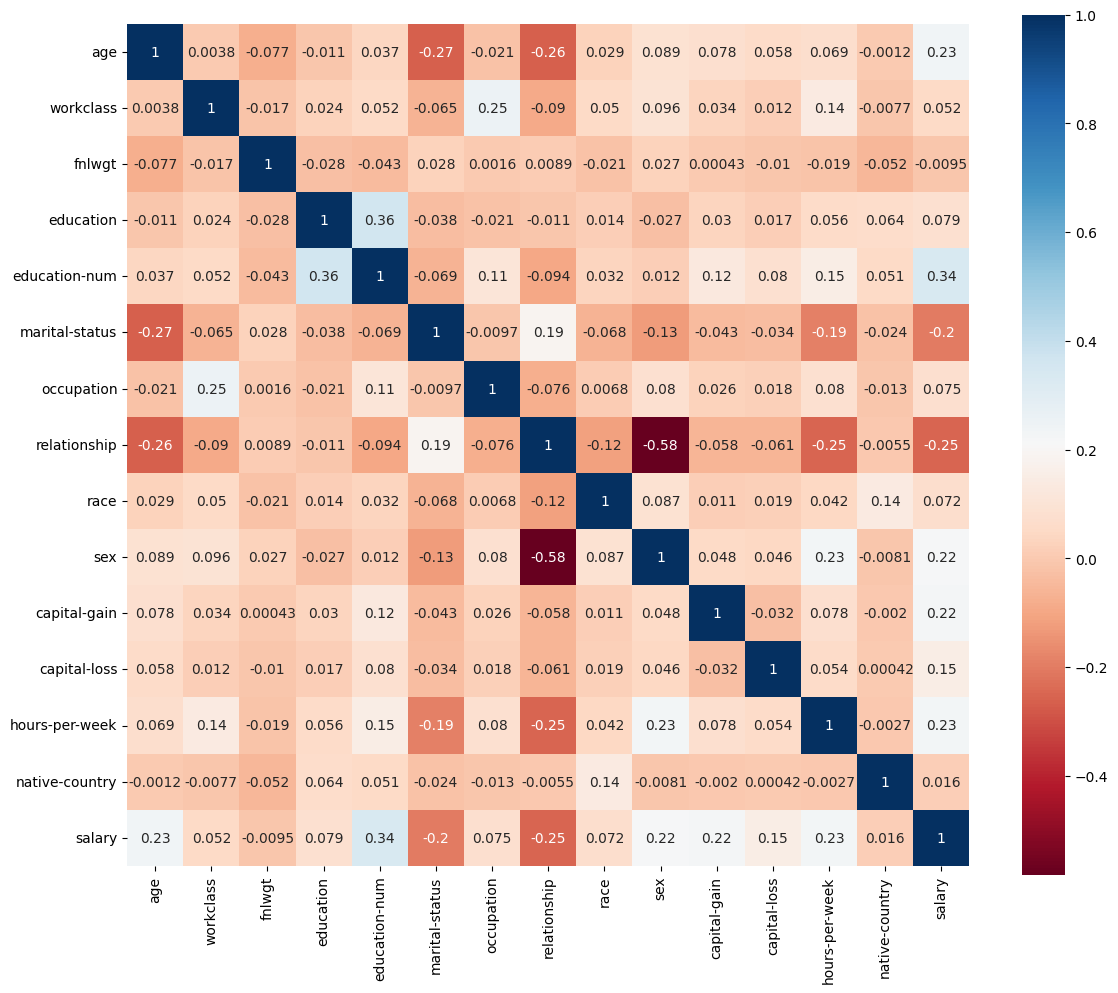

In [ ]:
colormap = plt.cm.RdBu

sns.heatmap(numerical_salary.corr(numeric_only=True), annot=True, cmap=colormap, square=True)

fig = plt.gcf()
fig.set_size_inches(12, 10)

plt.tight_layout()
plt.show()

### As shown in the heat map, the features which have the highest impact on the salary are:

*   education
*   age
*   hours of work per week


### We also observed that there is a high correlation between relationship and sex.


In [ ]:
gain_by_country = train_set.groupby(["native-country"]).agg(capital_gain=("capital-gain", 'mean'))
gain_by_country = gain_by_country.reset_index()

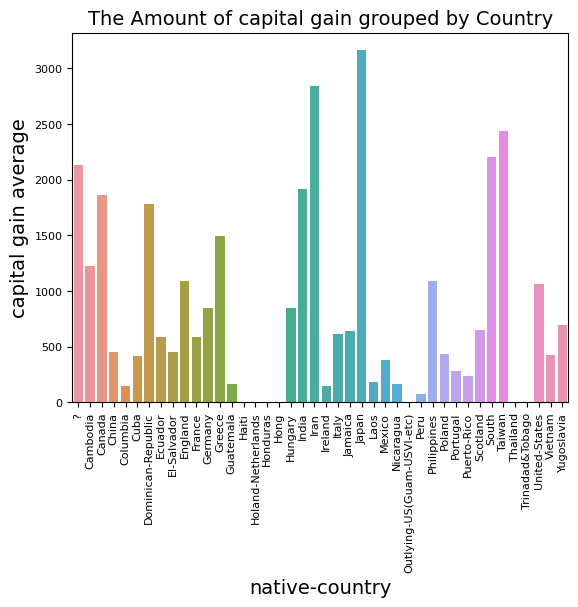

In [ ]:
plt.title("The Amount of capital gain grouped by Country", fontsize=14)
sns.barplot(x="native-country",
            y="capital_gain",
            data=gain_by_country)


plt.xlabel('native-country', fontsize=14);
plt.ylabel('capital gain average', fontsize=14);

plt.tick_params(axis='both', which='major', labelsize=8)

plt.xticks(rotation=90)

plt.show()

# **2. Which countries have the biggest gaps in salaries between males and females?**

### In the **United-States** case, we'll handle it seperately because of the large numbers

<Axes: title={'center': 'US Gaps'}, xlabel='native-country'>

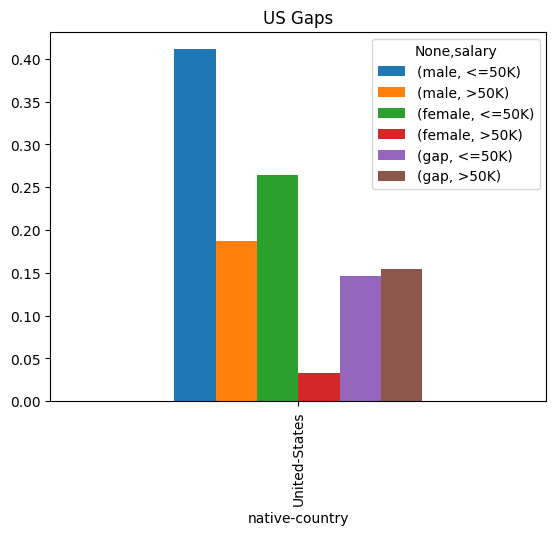

In [27]:
filtered_data = salary[salary["native-country"] == "United-States"]

data = filtered_data.groupby(["native-country",  "salary"]).apply(lambda x: pd.Series({
   "male" : (x.sex == 'Male').sum() / len(salary) ,
   "female" :(x.sex == 'Female').sum() / len(salary)
}))
data = data.reset_index()


data["gap"] = abs(data["male"] - data["female"])

data = data.nlargest(10, "gap")

data.set_index(['native-country','salary']).unstack().plot.bar(title= 'US Gaps')

### All countries but the US

In [29]:
filtered_data = salary[salary["native-country"] != "United-States"]
# count=("salary", 'count') , Female = ("sex" , "count") , Male = ("sex","count")
data = filtered_data.groupby(["native-country",  "salary"]).apply(lambda x: pd.Series({
   "male" : (x.sex == 'Male').sum() / len(salary) ,
   "female" :(x.sex == 'Female').sum() / len(salary)
}))
data = data.reset_index()

data["gap"] = abs(data["male"] - data["female"])

data = data.nlargest(10, "gap")

data

,native-country,salary,male,female,gap
51,Mexico,<=50K,0.014312,0.004422,0.009889
0,?,<=50K,0.008937,0.004484,0.004453
1,?,>50K,0.003962,0.000522,0.003440
37,India,<=50K,0.001566,0.000276,0.001290
59,Philippines,>50K,0.001505,0.000369,0.001136
38,India,>50K,0.001167,0.000061,0.001106
23,Germany,>50K,0.001136,0.000215,0.000921
16,El-Salvador,<=50K,0.001935,0.001044,0.000891
52,Mexico,>50K,0.000952,0.000061,0.000891
6,China,<=50K,0.001198,0.000491,0.000706


<Axes: xlabel='native-country'>

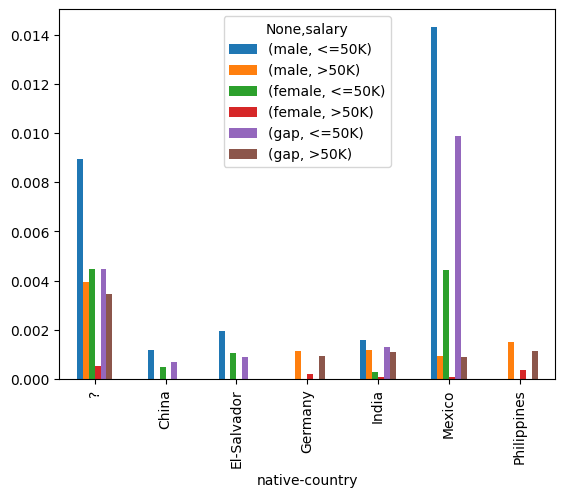

In [30]:
data.set_index(['native-country','salary']).unstack().plot.bar()

###Gaps where the salary is less than or equal to 50k

<Axes: title={'center': 'Salary <= 50k'}, xlabel='native-country'>

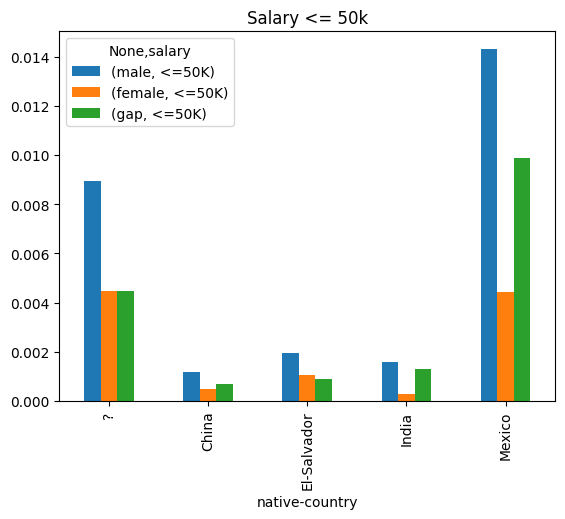

In [31]:
data_fil = data[data['salary'] == '<=50K']
data_fil.set_index(['native-country','salary']).unstack().plot.bar(title= "Salary <= 50k")

### Gaps where the salary is greater than 50k

<Axes: title={'center': 'Salary > 50k'}, xlabel='native-country'>

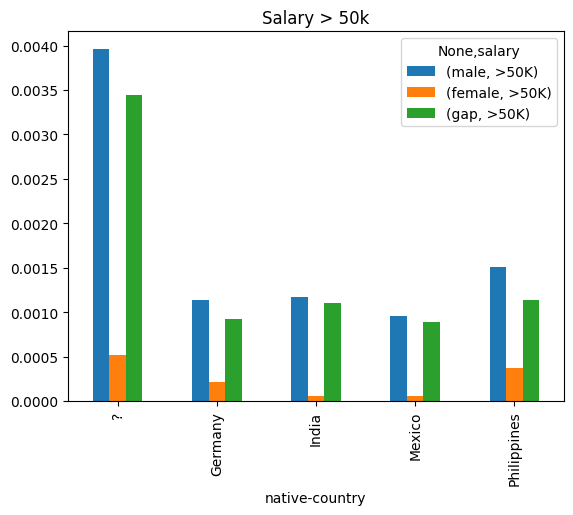

In [32]:
data_fil = data[data['salary'] == '>50K']
data_fil.set_index(['native-country','salary']).unstack().plot.bar(title='Salary > 50k')

# **3. How does education affect the salary?**

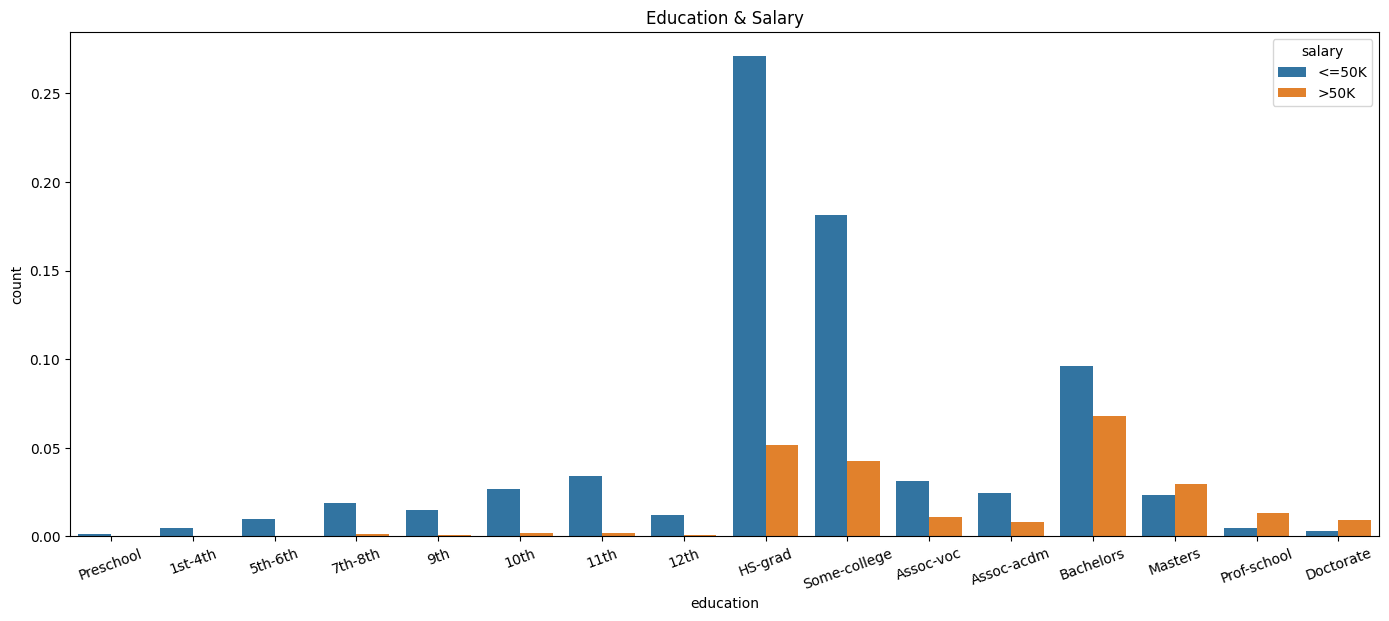

In [39]:
data = salary.groupby(['salary' , 'education' , 'education-num']).agg(count = ('salary' , 'count'))
data = data.reset_index()
data = data.sort_values(by="education-num" )

data['count'] = data['count'] / len(salary)

plt.figure(figsize=(14, 6))
plt.title("Education & Salary")
sns.barplot(data=data, x="education", y = 'count',hue="salary")
plt.tight_layout()
plt.xticks(rotation=20)
plt.show()


# **4. Which countries have the highest working hours?**

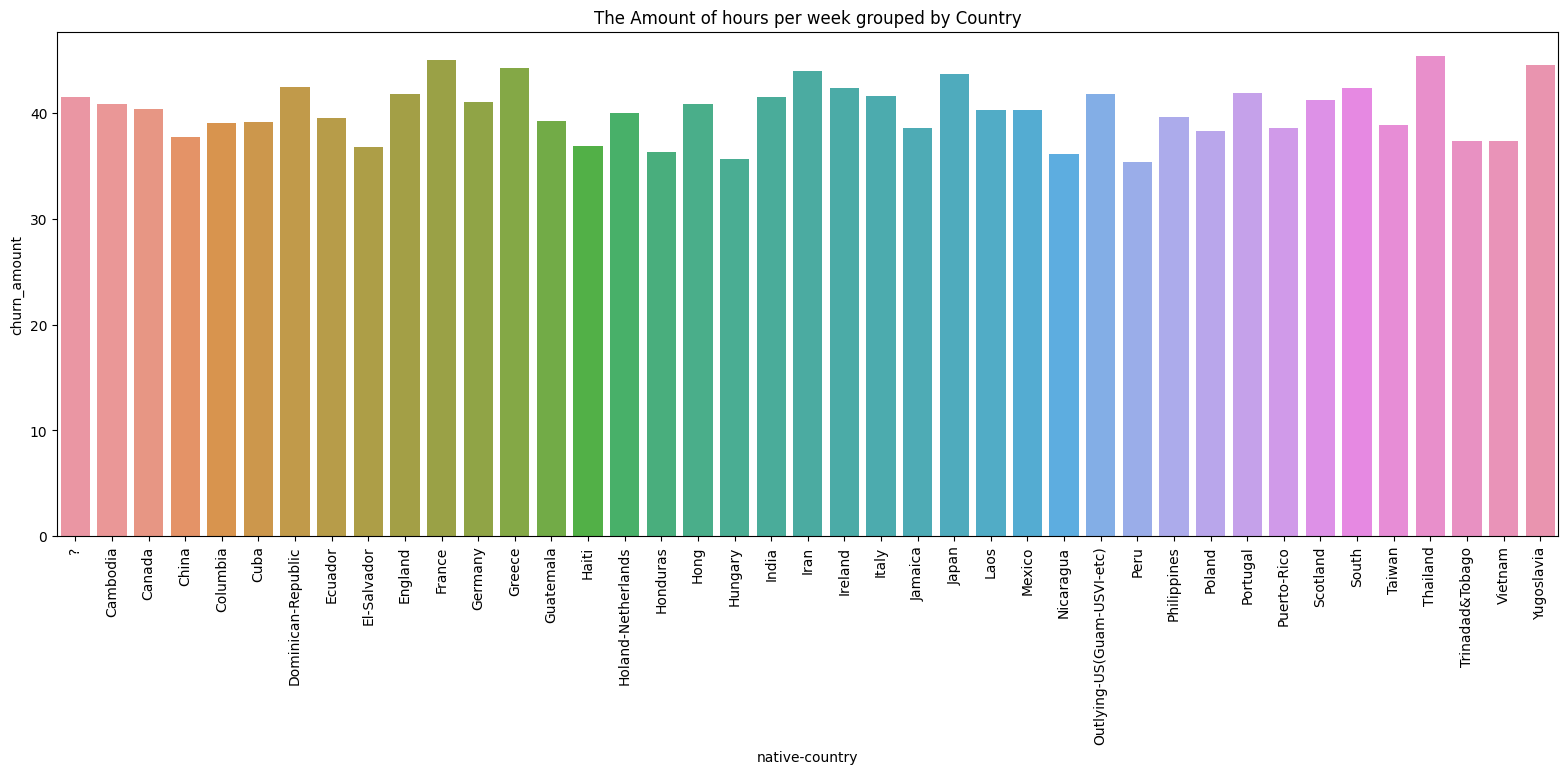

In [45]:
filtered_data = salary[salary["native-country"] != "United-States"]

salary_avg_by_country_no_us = filtered_data.groupby(["native-country"]).agg(churn_amount=("hours-per-week", 'mean'))
salary_avg_by_country_no_us = salary_avg_by_country_no_us.reset_index()

plt.figure(figsize=(16, 6))
plt.title("The Amount of hours per week grouped by Country")
sns.barplot(x="native-country",
            y="churn_amount",
            data=salary_avg_by_country_no_us)
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

# **5. How do the salaries differ based on race?**

In [ ]:
data = salary.groupby('race').agg(count = ("race" , "count")).reset_index()
data.head()

,race,count
0,Amer-Indian-Eskimo,311
1,Asian-Pac-Islander,1039
2,Black,3124
3,Other,271
4,White,27816


In [46]:
data = salary.groupby(['race' , 'salary']).agg(count = ("race" , "count")).reset_index()
data.head(10)
data['count'] = data['count'] / len(salary)

<Axes: title={'center': 'Salaries & Race'}, xlabel='race'>

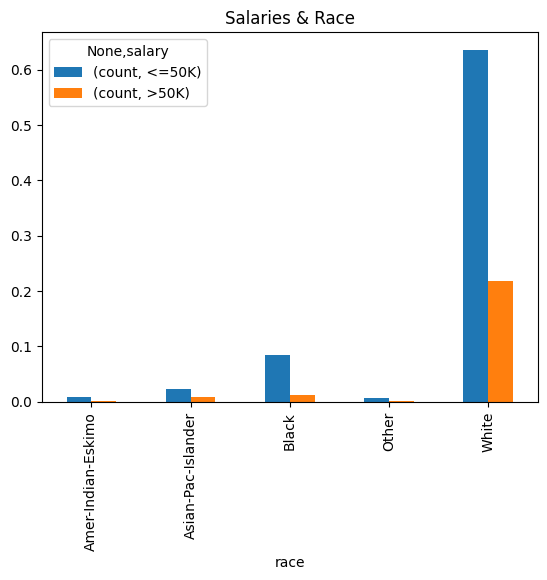

In [47]:
data.set_index(['race', 'salary']).unstack().plot.bar(title='Salaries & Race')

# **6. Which occupation has the highest amount of working hours?**

In [48]:
data = salary.groupby('occupation').agg(hours = ("hours-per-week" , 'mean')).reset_index()
data = data.sort_values(by= 'hours')
data

,occupation,hours
0,?,31.906131
9,Priv-house-serv,32.885906
8,Other-service,34.701669
1,Adm-clerical,37.558355
6,Handlers-cleaners,37.947445
13,Tech-support,39.432112
2,Armed-Forces,40.666667
7,Machine-op-inspct,40.755744
12,Sales,40.781096
3,Craft-repair,42.304221


<Axes: title={'center': 'Occupations hours'}, xlabel='None,occupation'>

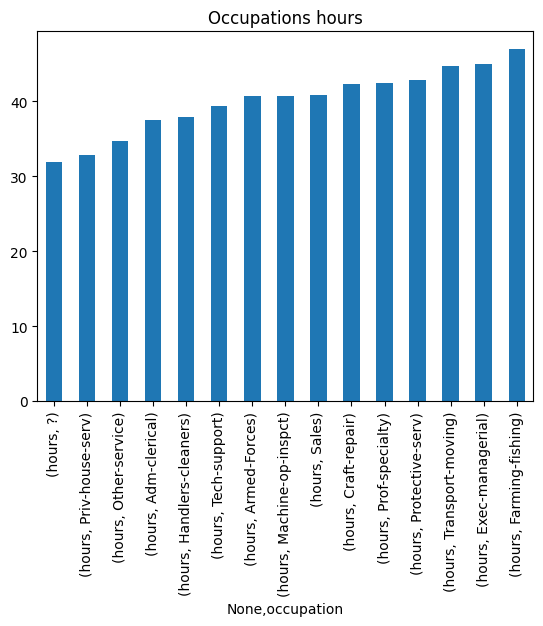

In [49]:
data.set_index('occupation').unstack().plot.bar(title = 'Occupations hours')

# **7. How does relationship status affect ones salary?**

In [50]:
data = salary.groupby(['relationship', 'salary'] ).agg(count = ("salary" , 'count')).reset_index()
data['count'] = data['count'] / len(salary)
data

,relationship,salary,count
0,Husband,<=50K,0.223427
1,Husband,>50K,0.181751
2,Not-in-family,<=50K,0.228771
3,Not-in-family,>50K,0.026289
4,Other-relative,<=50K,0.028992
5,Other-relative,>50K,0.001136
6,Own-child,<=50K,0.153589
7,Own-child,>50K,0.002058
8,Unmarried,<=50K,0.099137
9,Unmarried,>50K,0.006695


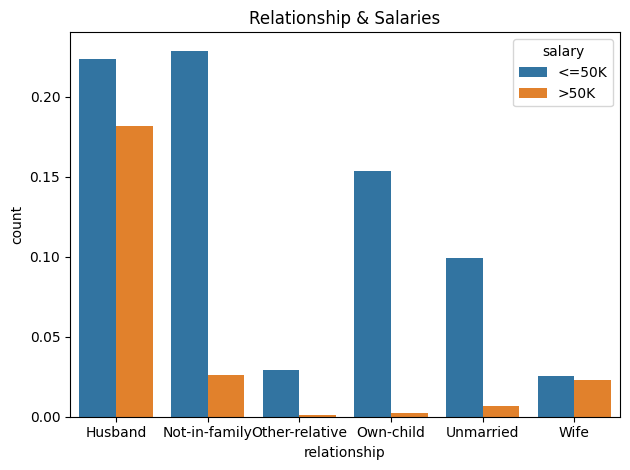

In [51]:

plt.title("Relationship & Salaries")
sns.barplot(x="relationship",
            y="count",
            hue = 'salary',
            data=data)
plt.tight_layout()
plt.show()

### Salary mean based on country

In [ ]:
data = salary.groupby('native-country').apply(lambda x: pd.Series({
    ">50K": x.salary.str.contains('>50K').sum() / len(x),
    "<=50K": x.salary.str.contains('<=50K').sum() / len(x),
})).reset_index()

data

,native-country,>50K,<=50K
0,?,0.250429,0.749571
1,Cambodia,0.368421,0.631579
2,Canada,0.322314,0.677686
3,China,0.266667,0.733333
4,Columbia,0.033898,0.966102
5,Cuba,0.263158,0.736842
6,Dominican-Republic,0.028571,0.971429
7,Ecuador,0.142857,0.857143
8,El-Salvador,0.084906,0.915094
9,England,0.333333,0.666667


### Top 3 countries with the highest mean for salaries above 50K

In [ ]:
data = salary.groupby('native-country').apply(lambda x: pd.Series({
    ">50K": x.salary.str.contains('>50K').sum() / len(x),
    "<=50K": x.salary.str.contains('<=50K').sum() / len(x),
})).reset_index()

data.sort_values(by='>50K' , ascending = False)[:3]

,native-country,>50K,<=50K
20,Iran,0.418605,0.581395
10,France,0.413793,0.586207
19,India,0.400000,0.600000


<Axes: title={'center': 'Salaries Country Means'}, xlabel='native-country'>

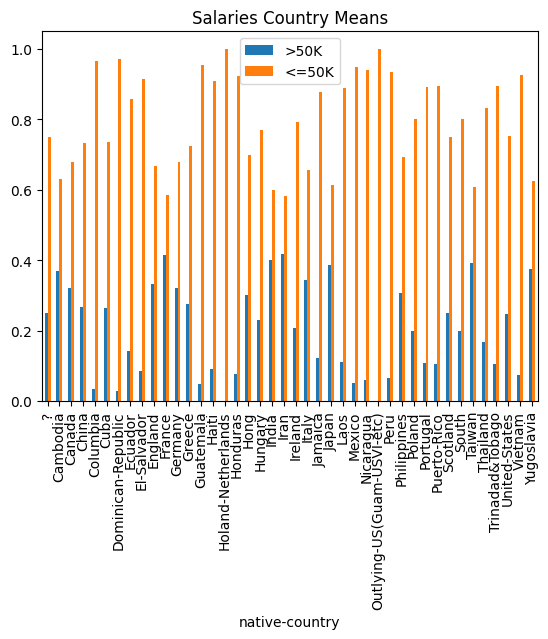

In [ ]:
data.set_index('native-country').plot.bar(title = 'Salaries Country Means')

# **Train the models**

### A small reminder of the different formulas

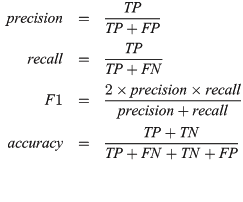

### Prepare the data for Machine Learning Algorithms

In [ ]:
# train_set_reduced is a temporary set
# After choosing the most promising model, we will train on the train_set as a whole
train_set_reduced, val_set = split_train_test_stratified(data=train_set, test_ratio=0.1)

In [ ]:
X_train = train_set_reduced.drop('salary', axis=1)  # drop creates a copy of the data
y_train = train_set_reduced['salary'].copy()

X_val = val_set.drop('salary', axis=1)
y_val = val_set['salary'].copy()

**CHALLENGE:**

Some columns are categorical features and contain string values. Although some models can handle categorical features (such as Decision Trees), there are models like SVM which require features to be numerical. These features need to be transformed to numerical values.

**SOLUTION:**

We will replace each category with a numerical value.

In [ ]:
MULTI_CAT_FEATURES = ['native-country','workclass','education','marital-status','occupation','relationship','race']
BIN_CAT_FEATURES = ['sex']
NUMERICAL_FEATURES = ['age', 'fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']

In [ ]:
pipeline = ColumnTransformer([
    ("num", StandardScaler(), NUMERICAL_FEATURES),
    ("one-hot", OneHotEncoder(), MULTI_CAT_FEATURES),
    ("binary-cat", OrdinalEncoder(), BIN_CAT_FEATURES)
])

In [ ]:
X_train_prepared = pipeline.fit_transform(X_train, y_train)
X_val_prepared = pipeline.transform(X_val)

In [ ]:
X_train_prepared.shape

(23443, 107)

In [ ]:
accuracy_array = []

In [ ]:
def display_evaluation(classifier_model, X, y, pred):
    # Print scores

    print("Classification Report:\n", classification_report(y, pred, zero_division=1))
    report = classification_report(y, pred, zero_division=1, output_dict=True)
    accuracy_array.append(report['accuracy'])

    # Plot non-normalized confusion matrix
    disp = ConfusionMatrixDisplay.from_estimator(
        classifier_model,
        X,
        y,
        cmap=plt.cm.Pastel1,
        normalize=None,
    )
    disp.ax_.set_title("Confusion Matrix")
    plt.tight_layout()
    plt.show()


### We've added the Dummy classifier as a baseline score, to try and see if we can do better than it

##**Dummy Classifier**

Classification Report:
               precision    recall  f1-score   support

       <=50K       0.76      1.00      0.86      1978
        >50K       1.00      0.00      0.00       627

    accuracy                           0.76      2605
   macro avg       0.88      0.50      0.43      2605
weighted avg       0.82      0.76      0.66      2605



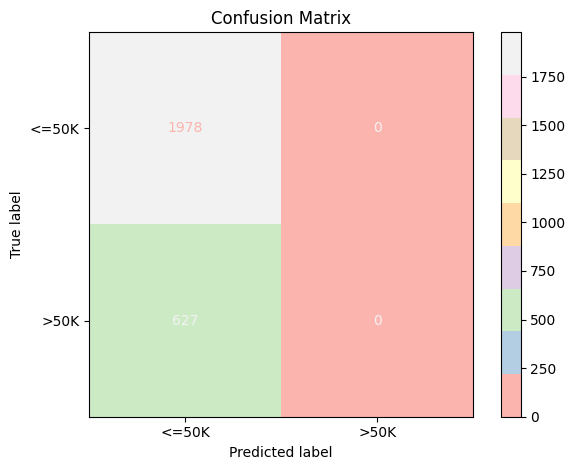

In [ ]:
baseline = DummyClassifier()
baseline.fit(X_train_prepared, y_train)
baseline_pred = baseline.predict(X_val_prepared)
display_evaluation(baseline, X_val_prepared, y_val, baseline_pred)

##**1. Decision Tree**

Classification Report:
               precision    recall  f1-score   support

       <=50K       0.88      0.87      0.88      1978
        >50K       0.61      0.63      0.62       627

    accuracy                           0.81      2605
   macro avg       0.75      0.75      0.75      2605
weighted avg       0.82      0.81      0.82      2605



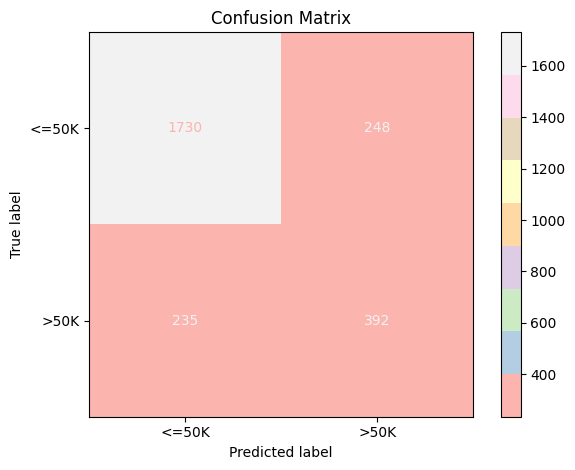

In [ ]:
tree = DecisionTreeClassifier(criterion='gini', splitter='best', random_state=RANDOM_STATE)
tree.fit(X_train_prepared, y_train)
tree_pred = tree.predict(X_val_prepared)
display_evaluation(tree, X_val_prepared, y_val, tree_pred)

##**2. *K* Nearest Neighbors**

Classification Report:
               precision    recall  f1-score   support

       <=50K       0.87      0.91      0.89      1978
        >50K       0.66      0.58      0.62       627

    accuracy                           0.83      2605
   macro avg       0.77      0.74      0.75      2605
weighted avg       0.82      0.83      0.82      2605



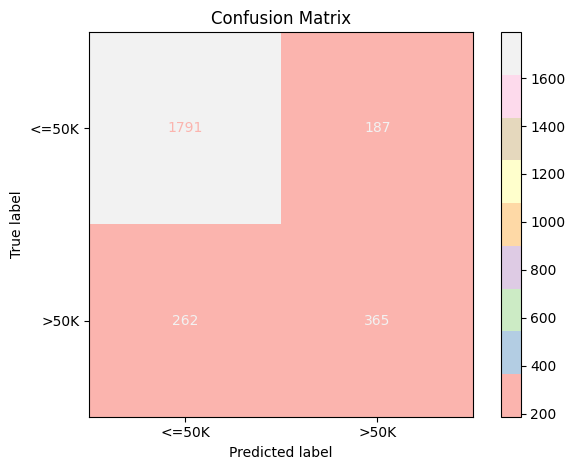

In [ ]:
knn = KNeighborsClassifier(n_neighbors=7, weights='uniform')
knn.fit(X_train_prepared, y_train)
knn_pred = knn.predict(X_val_prepared)
display_evaluation(knn, X_val_prepared, y_val, knn_pred)

##**3. Logistic Regression**

Classification Report:
               precision    recall  f1-score   support

       <=50K       0.88      0.92      0.90      1978
        >50K       0.71      0.60      0.65       627

    accuracy                           0.84      2605
   macro avg       0.79      0.76      0.77      2605
weighted avg       0.84      0.84      0.84      2605



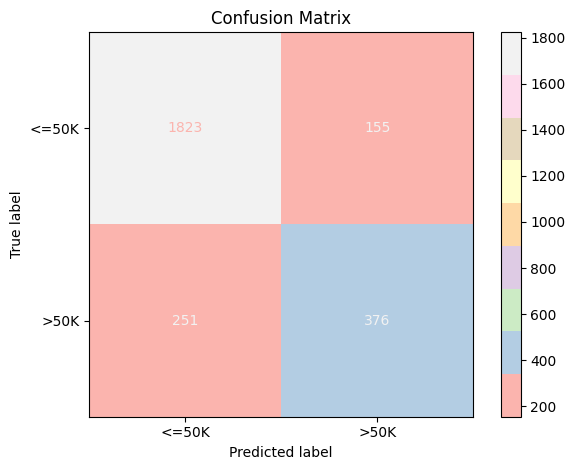

In [ ]:
logistic = LogisticRegression(penalty='l2', random_state=RANDOM_STATE, max_iter=1000)
logistic.fit(X_train_prepared, y_train)
logistic_pred = logistic.predict(X_val_prepared)
display_evaluation(logistic, X_val_prepared, y_val, logistic_pred)

## **4. SVM**

Classification Report:
               precision    recall  f1-score   support

       <=50K       0.88      0.93      0.91      1978
        >50K       0.74      0.59      0.66       627

    accuracy                           0.85      2605
   macro avg       0.81      0.76      0.78      2605
weighted avg       0.85      0.85      0.85      2605



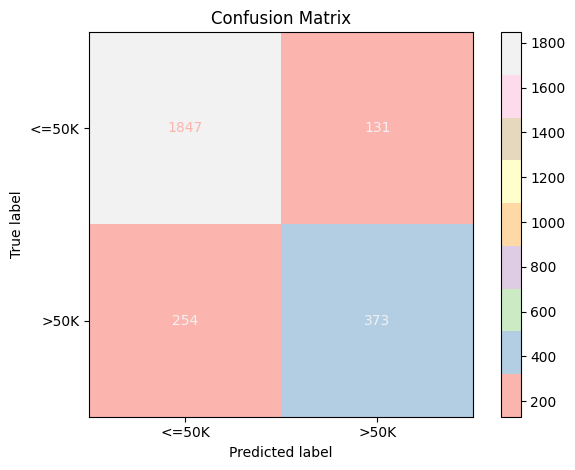

In [ ]:
svm = SVC(kernel='rbf', degree=3, coef0=0.0, C=1, random_state=RANDOM_STATE)
svm.fit(X_train_prepared, y_train)
svm_pred = svm.predict(X_val_prepared)
display_evaluation(svm, X_val_prepared, y_val, svm_pred)

## **5. Adaboost**

Classification Report:
               precision    recall  f1-score   support

       <=50K       0.88      0.87      0.88      1978
        >50K       0.61      0.64      0.62       627

    accuracy                           0.82      2605
   macro avg       0.75      0.75      0.75      2605
weighted avg       0.82      0.82      0.82      2605



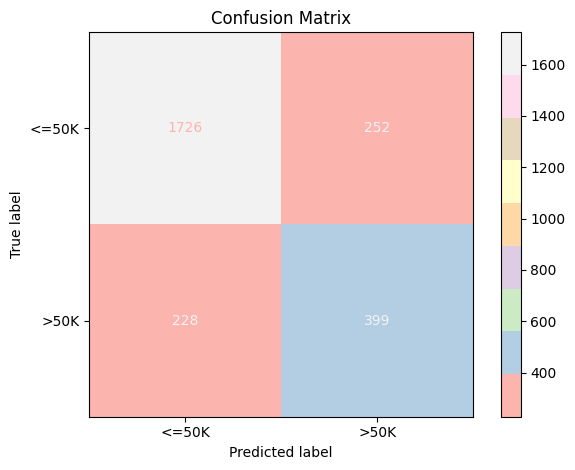

In [ ]:
adaboost = AdaBoostClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, learning_rate=1.0, random_state=RANDOM_STATE)
adaboost.fit(X_train_prepared, y_train)
adaboost_pred = adaboost.predict(X_val_prepared)
display_evaluation(adaboost, X_val_prepared, y_val, adaboost_pred)

## **6.Perceptron**

Classification Report:
               precision    recall  f1-score   support

       <=50K       0.90      0.80      0.85      1978
        >50K       0.54      0.72      0.61       627

    accuracy                           0.78      2605
   macro avg       0.72      0.76      0.73      2605
weighted avg       0.81      0.78      0.79      2605



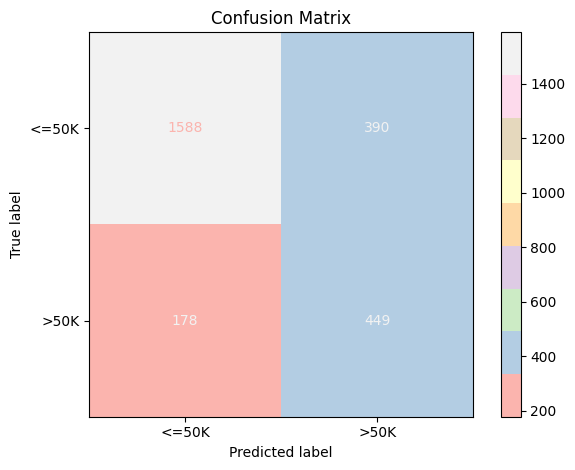

In [ ]:
perceptron = Perceptron(tol=1e-3, random_state=0)
perceptron.fit(X_train_prepared, y_train)
perceptron_pred = perceptron.predict(X_val_prepared)
display_evaluation(perceptron, X_val_prepared, y_val, perceptron_pred)

## In the graph below, we can see that the models which give us the best results are **KNN**, **SVM** and **Logistic Regression**. Let's try to improve their results

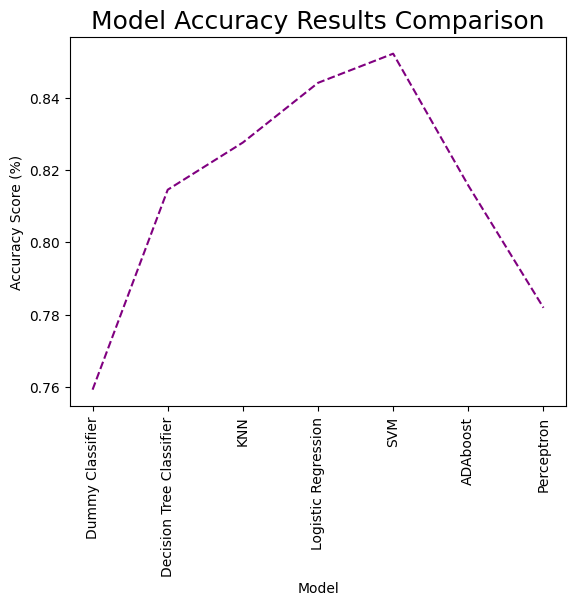

In [ ]:
arrX = ['Dummy Classifier','Decision Tree Classifier','KNN', 'Logistic Regression','SVM', 'ADAboost','Perceptron']
plt.plot (arrX, accuracy_array, linestyle='--',color='purple')
plt.title("Model Accuracy Results Comparison", fontsize = 18)
plt.xticks(rotation=90)
plt.xlabel("Model")
plt.ylabel("Accuracy Score (%)")
plt.show()

### Worst Model

We observe that the worst model for this data set is **perceptron**, its maybe due to the small data set which consists of only 30K records,
Or it could be due to the way perceptron works, The model relay on that the data is linearly separable.

In [ ]:
accuracy_array

[0.7593090211132437,
 0.8145873320537428,
 0.8276391554702495,
 0.8441458733205375,
 0.8522072936660269,
 0.8157389635316699,
 0.781957773512476]

## **Let's try and improve our results**

In [ ]:
X_train = train_set.drop('salary', axis=1)  # drop creates a copy of the data
y_train = train_set['salary'].copy()

X_train_prepared = pipeline.fit_transform(X_train, y_train)


## ***K* Nearest Neighbors**

In [ ]:
knn_param_grid = [
    {
        'n_neighbors': [7, 9, 13,15],
        'weights': ['uniform', 'distance'],
        'metric': ['l1', 'l2'],
    }
]

In [ ]:
knn_grid_cv = GridSearchCV(clone(knn),
                           knn_param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1)
knn_grid_cv.fit(X_train_prepared, y_train)
print(f"Best Params: {knn_grid_cv.best_params_}")
print(f"Best Score: {knn_grid_cv.best_score_}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Params: {'metric': 'l2', 'n_neighbors': 13, 'weights': 'uniform'}
Best Score: 0.841530664681045


## **SVM**

In [ ]:
svm_param_grid = [
    {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': [0.01, 0.1, 1]
    }
]

In [ ]:
svm_grid_cv = GridSearchCV(clone(svm),
                           svm_param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=2)
svm_grid_cv.fit(X_train_prepared, y_train)
print(f"Best Params: {svm_grid_cv.best_params_}")
print(f"Best Score: {svm_grid_cv.best_score_}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=  16.7s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=  16.6s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=  17.0s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=  16.3s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=  16.5s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=  19.1s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=  19.5s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=  18.9s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=  19.2s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=  19.8s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=  16.2s
[CV] END ....................C=0.1, gamma=0.1, k

## **Logistic Regression**

In [ ]:
grid={"C":np.logspace(-3,3,7), "penalty":["l2"]}# l2 ridge
logreg=LogisticRegression(solver='lbfgs', max_iter=3000)
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train_prepared, y_train)

print(f"Best Params: {logreg_cv.best_params_}")
print(f"Best Score: {logreg_cv.best_score_}")

Best Params: {'C': 10.0, 'penalty': 'l2'}
Best Score: 0.8508904357978718


## **Decision Tree Classifier**

In [ ]:
decision_param = {'max_features': ['sqrt'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [5, 6, 7, 8, 9],
              'criterion' :['gini', 'entropy']
             }

In [ ]:
decision_grid = GridSearchCV(clone(decision), param_grid=decision_param, cv=5, verbose=True)
decision_grid.fit(x_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': [0.1, 0.01, 0.001],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 6, 7, 8, 9],
                         'max_features': ['sqrt']},
             verbose=True)

In [ ]:
final_model = decision_grid.best_estimator_
final_model

DecisionTreeClassifier(ccp_alpha=0.001, criterion='entropy', max_depth=9,
                       max_features='sqrt')

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.94      0.89      1978
           1       0.71      0.48      0.57       627

    accuracy                           0.83      2605
   macro avg       0.78      0.71      0.73      2605
weighted avg       0.82      0.83      0.81      2605



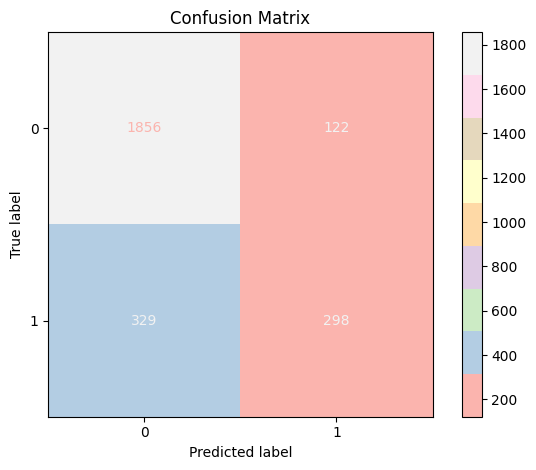

In [ ]:
#Training the model
decision = final_model
decision.fit(x_train, y_train)
decision_pred = decision.predict(x_test)
display_evaluation(decision, x_test, y_test, decision_pred)

## **Adaboost**

In [ ]:
adaboost_param = dict()
adaboost_param['n_estimators'] = [10, 50, 100, 500]
adaboost_param['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]

from sklearn.model_selection import RepeatedStratifiedKFold
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [ ]:
adaboost_grid = GridSearchCV(estimator=clone(adaboost), param_grid=adaboost_param, n_jobs=-1, cv=cv, scoring='accuracy')
adaboost_grid.fit(x_train, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                          random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
                         'n_estimators': [10, 50, 100, 500]},
             scoring='accuracy')

In [ ]:
final_model = adaboost_grid.best_estimator_
final_model

AdaBoostClassifier(estimator=DecisionTreeClassifier(), learning_rate=0.1,
                   n_estimators=10, random_state=42)

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.89      0.88      1978
           1       0.63      0.60      0.61       627

    accuracy                           0.82      2605
   macro avg       0.75      0.74      0.75      2605
weighted avg       0.81      0.82      0.82      2605



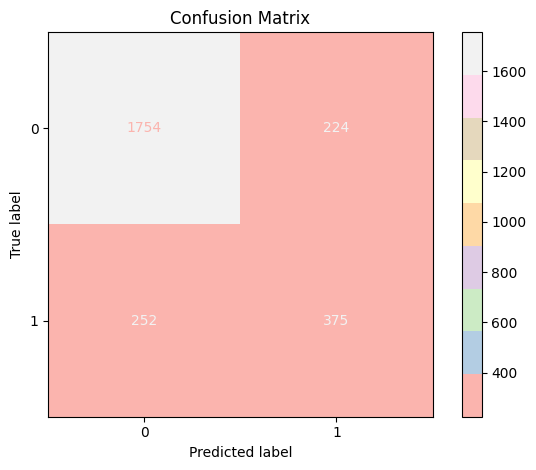

In [ ]:
adaboost = final_model
adaboost.fit(x_train, y_train)
adaboost_pred = adaboost.predict(x_test)
display_evaluation(adaboost, x_test, y_test, adaboost_pred)

# **Testing the final model**

In [ ]:
X_test = test_set.drop('salary', axis=1)
y_test = test_set['salary'].copy()

X_test_prepared = pipeline.transform(X_test)

## ***K* Nearest Neighbors**

Classification Report:
               precision    recall  f1-score   support

       <=50K       0.88      0.92      0.90      4945
        >50K       0.71      0.62      0.66      1568

    accuracy                           0.85      6513
   macro avg       0.79      0.77      0.78      6513
weighted avg       0.84      0.85      0.84      6513



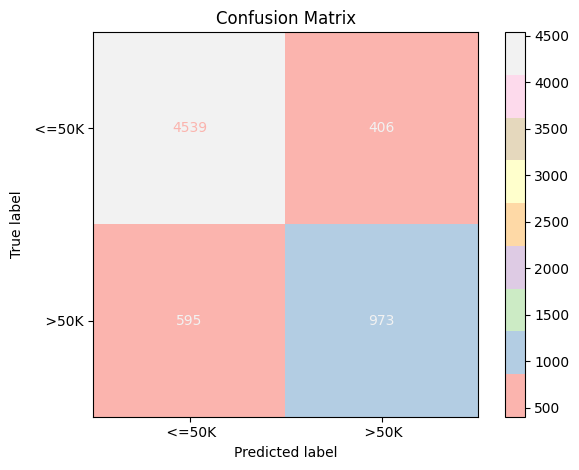

In [ ]:
knn_final = knn_grid_cv.best_estimator_
knn_final_pred = knn_final.predict(X_test_prepared)
display_evaluation(knn_final, X_test_prepared, y_test, knn_final_pred)

## **SVM**

In [ ]:
svm_grid_cv.get_params

<bound method BaseEstimator.get_params of GridSearchCV(cv=5, estimator=SVC(C=1, random_state=42),
             param_grid=[{'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1],
                          'kernel': ['linear', 'rbf']}],
             scoring='accuracy', verbose=2)>

Classification Report:
               precision    recall  f1-score   support

       <=50K       0.89      0.96      0.92      4945
        >50K       0.82      0.63      0.71      1568

    accuracy                           0.88      6513
   macro avg       0.86      0.79      0.82      6513
weighted avg       0.87      0.88      0.87      6513



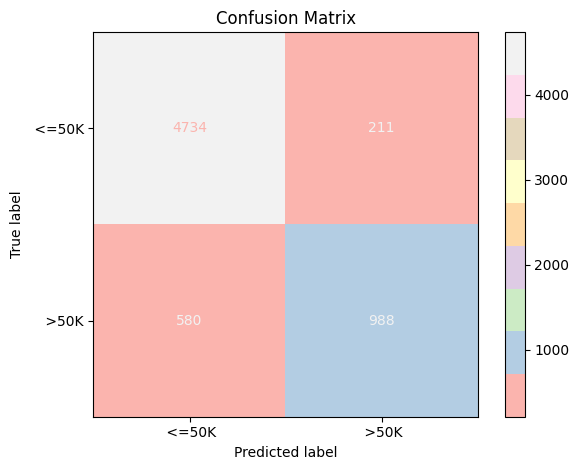

In [ ]:
svm_final = SVC(C= 1, gamma= 0.1, kernel= 'rbf')
svm_final.fit(X_test_prepared, y_test)
svm_final_pred = svm_final.predict(X_test_prepared)
display_evaluation(svm_final, X_test_prepared, y_test, svm_final_pred)

## **Logistic Regression**

Classification Report:
               precision    recall  f1-score   support

       <=50K       0.89      0.93      0.91      4945
        >50K       0.74      0.62      0.67      1568

    accuracy                           0.86      6513
   macro avg       0.81      0.78      0.79      6513
weighted avg       0.85      0.86      0.85      6513



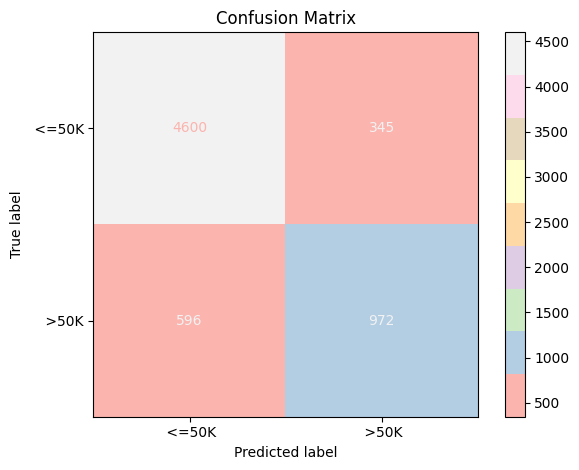

In [ ]:
logistic_final = logreg_cv.best_estimator_
logistic_final_pred = logistic_final.predict(X_test_prepared)
display_evaluation(logistic_final, X_test_prepared, y_test, logistic_final_pred)

# As we can see, we have succeeded in increasing our accuracy!

# **The end**